In [78]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.Displacement.generation import WCGAN_GP
from dataset.Displacement.DataGeneration import DamageDataGenerationDataset
from model.Displacement.extraction import AE, TripletAE, DamageAE
from model.Displacement.regression import CNN
from torch.utils.data import DataLoader

In [79]:
# feature_Extractor = CNN.load_from_checkpoint("Logs/Identification/Displacement-regression/From_scratch/version_2/checkpoints/epoch=00343-val_loss=0.0000.ckpt").model.to("cuda")
feature_Extractor = AE.load_from_checkpoint("./Logs/Extraction/Displacement-AE/LAST/version_0/checkpoints/epoch=00195-val_loss=0.00002329.ckpt").to("cuda")
# feature_Extractor = TripletAE.load_from_checkpoint("./Logs/Extraction/Displacement-TripletAE/LAST/version_0/checkpoints/epoch=00184-val_loss=0.00032279.ckpt").to("cuda")
WCGAN = WCGAN_GP.load_from_checkpoint("./Logs/Generation/Displacement_WCGAN_GP/stride_dataset/version_0/checkpoints/epoch=00499.ckpt", strict=False).to("cuda")

In [80]:
train_dataset = DamageDataGenerationDataset(path="./Data", task="classification")
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) 

#### Baseline

In [81]:
real_representation_list = []
condition_list = []
with torch.no_grad():
    for real_data, condition, situation in train_dataloader:
        real_data = real_data.to("cuda")
        real_representation_list += feature_Extractor(real_data)[-1].unsqueeze(0)
        condition_list += condition.unsqueeze(0)

    real_representation_list = torch.concat(real_representation_list).cpu().numpy()
    condition_list = torch.concat(condition_list).cpu().numpy()

In [82]:
real_representation_list.shape

(17105, 1024, 1)

In [83]:
index = int(real_representation_list.shape[0]/2)
fid = WCGAN.calculate_fid(real_representation_list[:index,:,:], real_representation_list[index:,:,:])
fjd = WCGAN.calculate_fjd(real_representation_list[:index,:,:], real_representation_list[index:,:,:], condition_list[:index,:], condition_list[index:,:])
print(f"Baseline FID: {fid:.4f}")
print(f"Baseline FJD: {fjd:.4f}")

Baseline FID: 0.0887
Baseline FJD: 0.1426


In [84]:
real_data_list = []
generative_data_list = []

real_representation_list = []
generative_representation_list = []
condition_list = []

situation_list = []

with torch.no_grad():
    for real_data, condition, situation in train_dataloader:
        z = torch.rand((condition.shape[0], 82)).to("cuda")
        condition = condition.to("cuda")
        real_data = real_data.to("cuda")

        synthetic_data = WCGAN(z, condition)

        real_data_list += real_data.unsqueeze(0)
        generative_data_list += synthetic_data.unsqueeze(0)
        condition_list += condition.unsqueeze(0)

        real_representation_list += feature_Extractor(real_data)[-1].unsqueeze(0)
        generative_representation_list += feature_Extractor(synthetic_data)[-1].unsqueeze(0)

        situation_list += situation.unsqueeze(0)


real_data_list = torch.concat(real_data_list).cpu().numpy()
generative_data_list = torch.concat(generative_data_list).cpu().numpy()

real_representation_list = torch.concat(real_representation_list).cpu().numpy()
generative_representation_list = torch.concat(generative_representation_list).cpu().numpy()
condition_list = torch.concat(condition_list).cpu().numpy()

situation_list = torch.concat(situation_list).cpu().numpy()

In [85]:
from sklearn.manifold import TSNE

def draw_tsne(synthetic_latent, input_latent, situation):
    synthetic_latent = np.reshape(synthetic_latent, (synthetic_latent.shape[0], -1))
    input_latent = np.reshape(input_latent, (input_latent.shape[0], -1))
    synthetic_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(synthetic_latent)
    real_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(input_latent)
    fig = plt.figure(figsize=(15,10))
    plt.scatter(synthetic_embedded[:, 0], synthetic_embedded[:, 1], c=situation,  marker="+", alpha=0.8, cmap="Set3")
    plt.scatter(real_embedded[:, 0], real_embedded[:, 1], c=situation, marker=".", alpha=0.8,  cmap="Set3")
    plt.savefig("Generation.svg", bbox_inches='tight')


In [86]:
def visualize(generated_data_sample, real_data_sample):
    fig, axes = plt.subplots(5, 1, figsize=(15,6), sharex=True)
    for i in range(5):
        line1 = axes[i].plot(range(len(real_data_sample[i, :])), real_data_sample[i, :], color="tab:blue",  label="Real Signal")
        line2 = axes[i].plot(range(len(generated_data_sample[i, :])), generated_data_sample[i, :], color="tab:red", linestyle='dashed', label="Generated Signal")
    fig.supylabel(r'$Displacement (m)$', x=0.07)
    fig.legend(handles =[line1[0], line2[0]], loc ='lower center', ncol=4)
    fig.savefig("Generated Siganl.svg", bbox_inches='tight')

In [87]:
def denormalize(generated_data, real_data):
    min_max = pd.read_csv("./Data/Displacement/min_max.csv").values
    n = generated_data.shape[0]
    for i in range(n):
        for j in range(5):
            generated_data[i, j, :] = generated_data[i, j, :] * (min_max[j, 1] - min_max[j, 0]) + min_max[j, 0]
            real_data[i, j, :] = real_data[i, j, :] * (min_max[j, 1] - min_max[j, 0]) + min_max[j, 0]

    return generated_data, real_data

In [88]:
fid = WCGAN.calculate_fid(generative_representation_list, real_representation_list)
fjd = WCGAN.calculate_fjd(generative_representation_list, real_representation_list, condition_list, condition_list)
print(f"FID: {fid:.4f}")
print(f"FJD: {fjd:.4f}")

FID: 20.5978
FJD: 40.2881


In [89]:
scale_generated_signal, scale_real_signal = denormalize(generative_data_list, real_data_list)

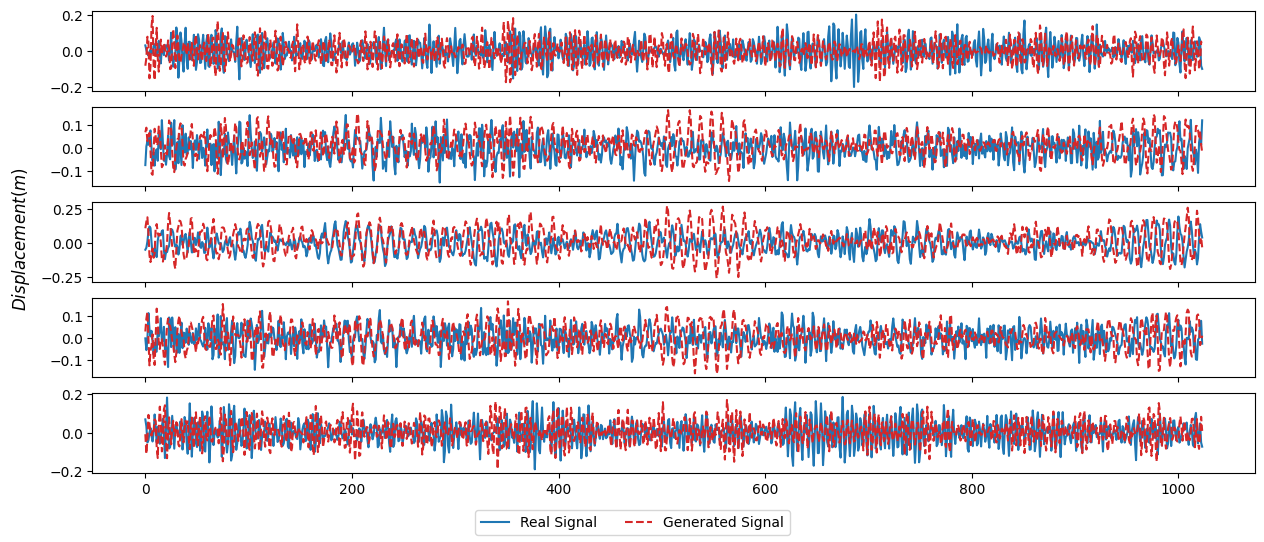

In [90]:
visualize(scale_generated_signal[0, :, :], scale_real_signal[0, :, :])

In [92]:
all_condition = []
for d7 in range(6):
    for d22 in range(6):
        for d38 in range(6):
            onehot7 = np.eye(6)[d7]
            onehot22 = np.eye(6)[d22]
            onehot38 = np.eye(6)[d38]
            temp = np.concatenate([onehot7, onehot22, onehot38])
            all_condition.append(temp)

In [97]:
np.array(all_condition).shape

(216, 18)

In [98]:
with torch.no_grad():
    for i in range(100):
        condition = torch.tensor(np.array(all_condition), dtype=torch.float32).to("cuda")
        z = torch.rand((condition.shape[0], 82)).to("cuda")
        synthetic_data = WCGAN(z, condition)

In [100]:
synthetic_data.shape

torch.Size([216, 5, 1024])